In [1]:
# Simulation imports
from reporting import simulation
from reporting.simulation import NORTH, EAST, SOUTH, WEST

In [2]:
# Library imports
import geopandas
import matplotlib
import shapely
from matplotlib import pyplot

# Day 1
A normal day...

In [3]:
simulation.day_1()

In [4]:
# Create a dictionary to represent a table of data
data = {
    'diagnosis': [], 'geometry': [], 'name': []
}
for r in Report.objects.all():
    data['diagnosis'].append(r.diagnosis)
    data['geometry'].append(shapely.geometry.Point(*r.location.coords))
    data['name'].append(r.patient_name)
    
cases = geopandas.GeoDataFrame(data=data, crs={'init': 'epsg:4326'})

In [5]:
from psycopg2 import connect
connection = connect(dbname='johnsnow')
cases = geopandas.read_postgis(
    "select * from reporting_report", connection,
    geom_col='location',
    crs={'init': 'epsg:4326'}
)


In [6]:
cases.sample(5)

,id,doctor_id,doctor_name,patient_id,patient_name,diagnosis,location,notes,created
90,1522,5745e164-163b-11e8-9233-f40f241e5fd7,Harry Mansi,5747141c-163b-11e8-83a8-f40f241e5fd7,David Kinsler,typhoid,POINT (-0.1491319204455255 51.5183478376043),,1857-06-01 10:00:00+00:00
68,1500,56f7b168-163b-11e8-8222-f40f241e5fd7,Anita Monroe,56f83c98-163b-11e8-8b69-f40f241e5fd7,Michael Greathouse,typhoid,POINT (-0.1099640169108141 51.49637311657707),,1857-06-01 15:00:00+00:00
17,1449,56465578-163b-11e8-a1a5-f40f241e5fd7,Pamela Durnin,56466342-163b-11e8-8f11-f40f241e5fd7,Gertrude Roberts,cholera,POINT (-0.1744656125962008 51.51139461488725),,1857-06-01 02:00:00+00:00
25,1457,565d6614-163b-11e8-a35b-f40f241e5fd7,Richard Leek,566101a2-163b-11e8-96f1-f40f241e5fd7,Margaret Wms,smallpox,POINT (-0.1224100569037081 51.52260289516482),,1857-06-01 08:00:00+00:00
95,1527,57598a8c-163b-11e8-9bfb-f40f241e5fd7,Cynthia Steinborn,575a5414-163b-11e8-ac61-f40f241e5fd7,Sheila Broadnax,typhoid,POINT (-0.148018286878053 51.51741407194108),,1857-06-01 04:00:00+00:00


In [7]:
# Set default size
matplotlib.rcParams['figure.figsize'] = [16.0, 12.0]

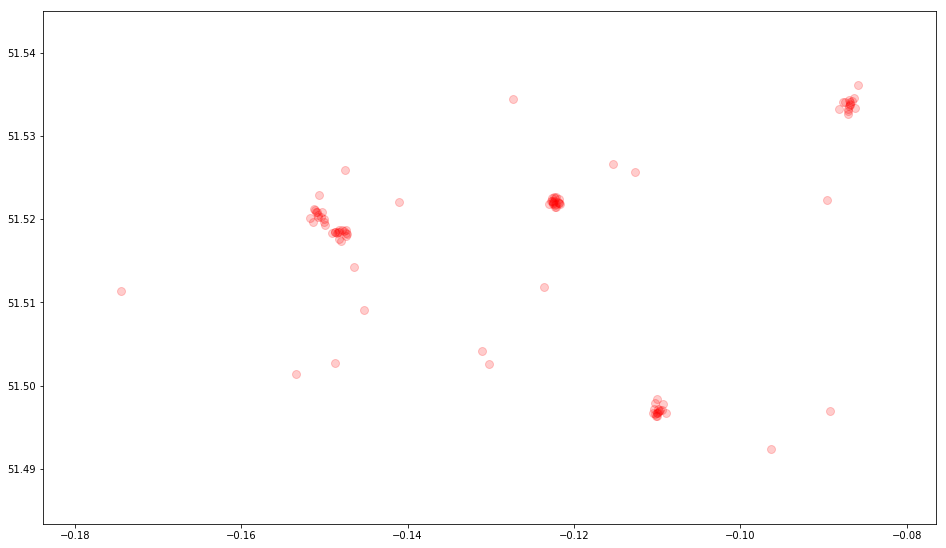

In [8]:
cases.plot(marker="o", color="red", markersize=64, alpha=0.2)

In [9]:
# Import London's rivers
rivers = geopandas.read_file('../data/london-rivers_shp/')

In [10]:
# Import London's roads
roads = geopandas.read_file('../data/london-roads_shp/')
# Filter the roads to just the most important ones
mains = roads[roads['highway'].isin(('trunk', 'primary', 'secondary', 'tertiary'))]

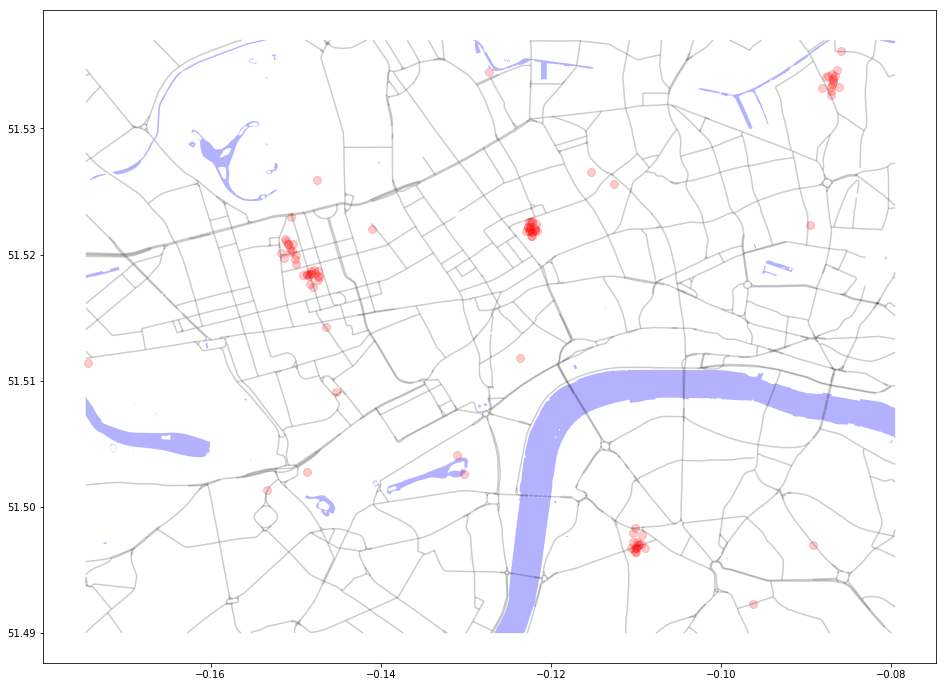

In [11]:
# Draw everything together
figure, axis = pyplot.subplots()
rivers_plot = rivers.plot(ax=axis, color='blue', alpha=0.3)
map_plot = mains.plot(ax=rivers_plot, color="black", alpha=0.2)
cases_plot = cases.plot(ax=map_plot, marker="o", color="red", markersize=64, alpha=0.2)

pyplot.show()

In [12]:
medical = geopandas.read_file('../data/london-medical_shp/')
hospitals = medical[medical['amenity'] == 'hospital'].copy()

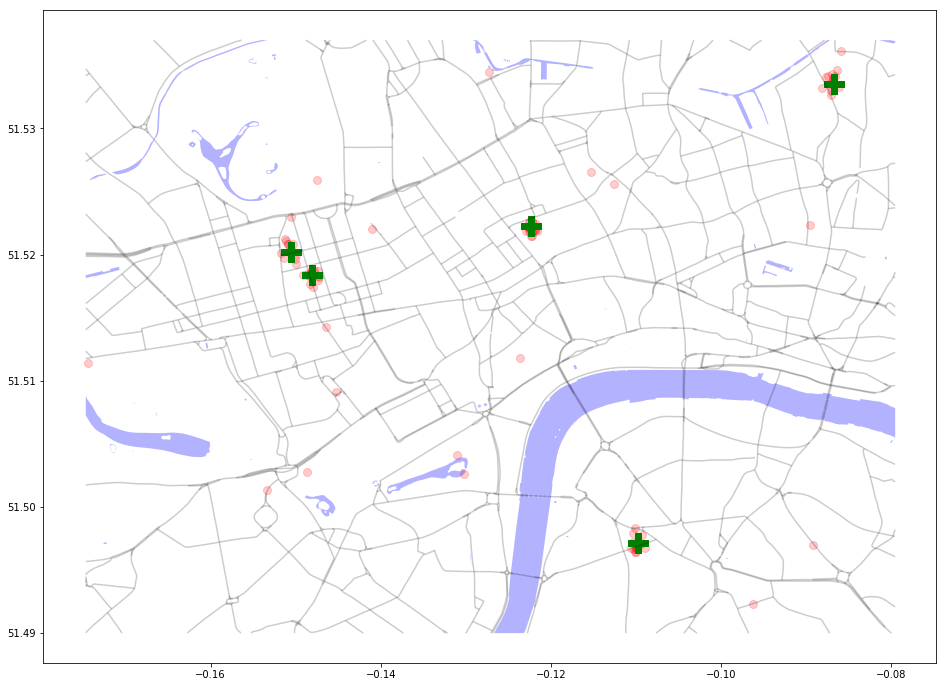

In [13]:
figure, axis = pyplot.subplots()
rivers_plot = rivers.plot(ax=axis, color='blue', alpha=0.3)
map_plot = mains.plot(ax=rivers_plot, color="black", alpha=0.2)
cases_plot = cases.plot(ax=map_plot, marker="o", color="red", markersize=64, alpha=0.2)
final = hospitals.plot(ax=cases_plot, marker="P", markersize=400, color="green")

pyplot.show()

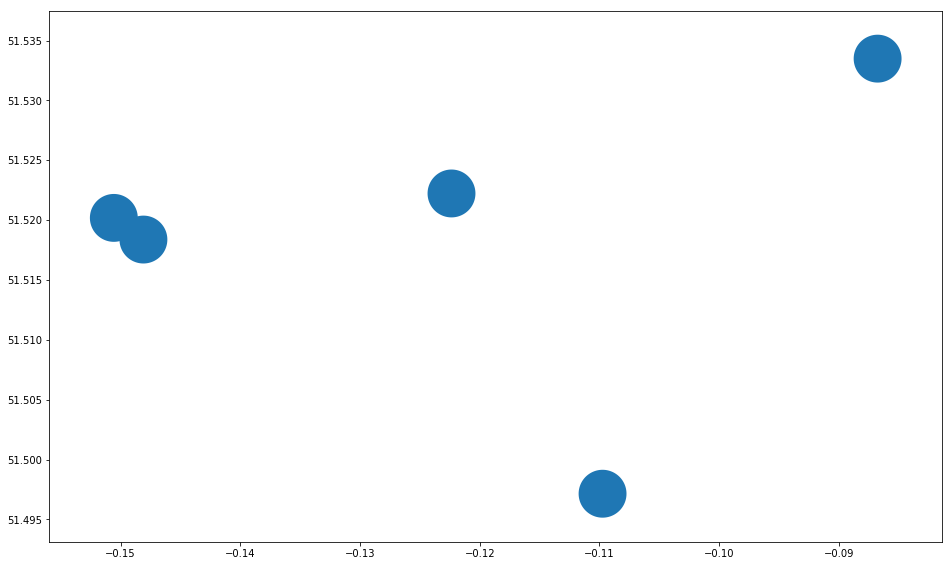

In [37]:
hospitals['geometry'] = hospitals['geometry'].buffer(0.001)
hospitals.plot()

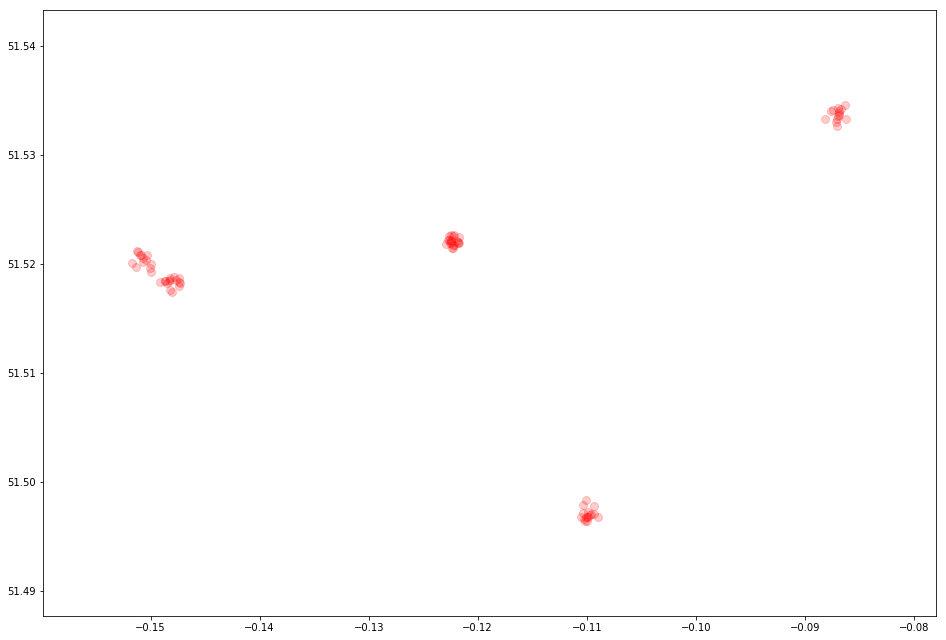

In [46]:
hospital_cases = geopandas.sjoin(cases, hospitals, op='within')
hospital_cases.plot(marker="o", color="red", markersize=64, alpha=0.2)

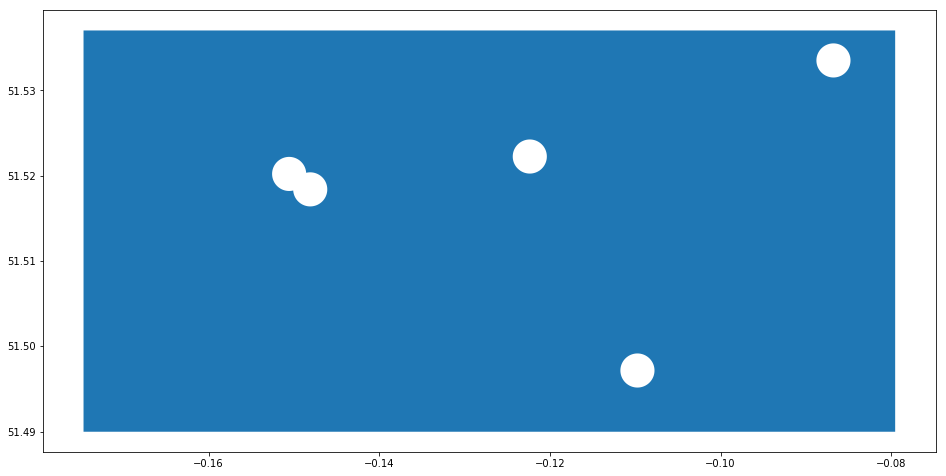

In [47]:
bounding_box = shapely.geometry.Polygon((
    (WEST, NORTH),
    (EAST, NORTH),
    (EAST, SOUTH),
    (WEST, SOUTH),
    (WEST, NORTH)
))
minus_hospital_zones = bounding_box.difference(hospitals.unary_union)
area_of_interest = geopandas.GeoDataFrame(
    {
        'geometry': [minus_hospital_zones],
        'name': ['Area of interest']
    },
    crs={'init': 'epsg:4326'}
)
area_of_interest.plot()

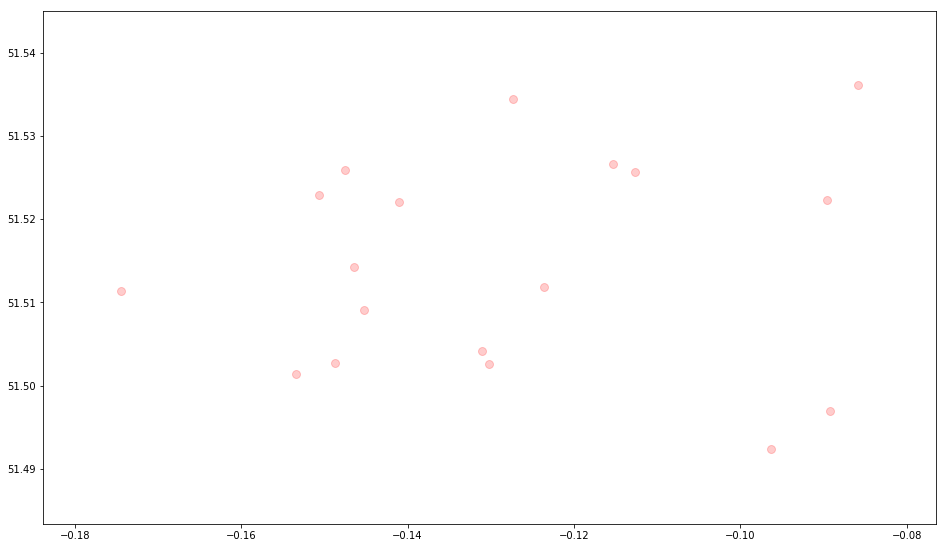

In [48]:
non_hospital_cases = geopandas.sjoin(cases, area_of_interest, op='within')
non_hospital_cases.plot(marker="o", color="red", markersize=64, alpha=0.2)